In [77]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.metrics import f1_score

mean_1 = np.array([1,2])
mean_2 = np.array([3,3])
cov_1 = np.array([[0.5, 0.3],[0.3, 0.5]])
cov_2 = np.array([[0.7, -0.3],[-0.3, 0.5]])

sigmoid = lambda a: 1/(1+np.exp(-a))
y = lambda w,Phi: sigmoid(np.matmul(Phi, w.reshape(-1,1)))
rbf = lambda x,mu=0,s=1: np.exp(-(x-mu)**2/(2*s**2))

def generate_dataset(N):
    Nh = int(N/2)
    order = np.random.permutation(N)
    X1 = st.multivariate_normal.rvs(mean_1, cov_1, Nh)
    X2 = st.multivariate_normal.rvs(mean_2, cov_2, Nh)
    X = np.concatenate((X1, X2))[order]
    T1 = np.zeros((Nh,1))
    T2 = np.ones((Nh,1))
    T = np.concatenate((T1,T2))[order]
    return X, T

def loss(Y, T):
    Y_temp = np.copy(Y)
    Y_temp[Y_temp == 1] = 1 - np.finfo(Y_temp.dtype).eps
    return - np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y_temp))

def Phi(X):
    I = np.ones((len(X),1))
    b1 = rbf(X[:,0],0.9,1).reshape(-1,1)
    b2 = rbf(X[:,1],4,1).reshape(-1,1)
      
    return np.concatenate((I, b1, b2), axis=1)

def gradient(w, Phi, T):
    Y = y(w, Phi)
    m = 1
    if(type(T)!=np.float64):
        m=len(T)
    return 1/m * np.matmul((Y - T).T, Phi)
    
def fit_vanilla(X, T, a = 1, epochs = 1000):
    w = np.zeros(X.shape[1])
    for epoch in range(epochs):
        G = gradient(w, X, T)
        w = w - a * G[0]
    return w

def fit_SGD(X, T, a = 1, epochs = 1000):
    w = np.zeros(X.shape[1])
    X_c = np.concatenate((X, T),axis=1)
    for epoch in range(epochs):
        np.random.shuffle(X_c[:])
        for elem in X_c:
            G = gradient(w, elem[:3].reshape(1,-1), elem[3])
            w = w - a * G[0]
    return w

def fit_minibatch(X, T, a = 1, epochs = 1000, batch_size= 32):
    w = np.zeros(X.shape[1])
    X_c = np.concatenate((X, T),axis=1)
    for epoch in range(epochs):
        batch = X_c[np.random.choice(X_c.shape[0], 2, replace=False), :]
        G = gradient(w, batch[:,:3], batch[:,3])
        w = w - a * G[0]
    return w

N = 200
a = 1
e = 100

X, T = generate_dataset(N)
Phi_X = Phi(X)
w_vanilla = fit_vanilla(Phi_X, T, a = a, epochs = e)
w_sgd = fit_SGD(Phi_X, T, a = a, epochs = e)
w_minibatch = fit_minibatch(Phi_X, T, a = a, epochs = e)

In [78]:
X_test, t_test = generate_dataset(200)
y_pred_vanilla = y(w_vanilla, Phi(X_test))
print("Vanilla w:", w_vanilla)
print("F1 Score:", f1_score(t_test, np.around(y_pred_vanilla)))
y_pred_sgd = y(w_sgd, Phi(X_test))
print("SGD: w:", w_sgd)
print("F1 Score:", f1_score(t_test, np.around(y_pred_sgd)))
y_pred_minibatch = y(w_minibatch, Phi(X_test))
print("Minibatch w:", w_minibatch)
print("F1 Score:", f1_score(t_test, np.around(y_pred_minibatch)))

Vanilla w: [ 0.90708065 -4.79328701  3.44559462]
F1 Score: 0.9145728643216081
SGD: w: [  0.7024156 -11.1721869   8.5397294]
F1 Score: 0.9052631578947369
Minibatch w: [-0.25496077 -2.09291342  1.32860034]
F1 Score: 0.7169811320754716


In [74]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', fit_intercept=False)
model.fit(Phi_X, T.ravel())
y_pred_sklearn = model.predict(Phi(X_test))

print("sklearn w:", model.coef_)
print("F1 Score:", f1_score(t_test, y_pred_sklearn))

sklearn w: [[ 1.0430126  -4.44659423  2.70668832]]
F1 Score: 0.9333333333333333


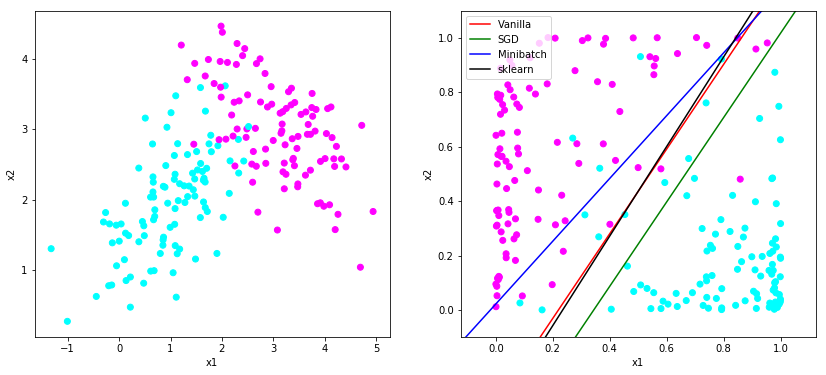

In [80]:
Phi_x1 = Phi_X[:,1]
Phi_x2 = Phi_X[:,2]
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c = T.reshape(len(T),), cmap='cool')
plt.xlabel("x1")
plt.ylabel("x2")

plt.subplot(1,2,2)
x1_offset = np.mean(Phi_x1)/4
x2_offset = np.mean(Phi_x2)/4
x1_min = np.min(Phi_x1) - x1_offset
x1_max = np.max(Phi_x1) + x1_offset
x2_min = np.min(Phi_x2) - x2_offset
x2_max = np.max(Phi_x2) + x2_offset
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.scatter(Phi_x1, Phi_x2, c = T.reshape(len(T),), cmap='cool')

X_plot = np.linspace(x1_min, x1_max, 2)
T_plot_1 = -(w1[0] + w1[1] * X_plot) / (w1[2])
plt.plot(X_plot, T_plot_1, c = 'r', label = "Vanilla")
T_plot_2 = -(w2[0] + w2[1] * X_plot) / (w2[2])
plt.plot(X_plot, T_plot_2, c = 'g', label = "SGD")
T_plot_3 = -(w3[0] + w3[1] * X_plot) / (w3[2])
plt.plot(X_plot, T_plot_3, c = 'b', label = "Minibatch")
T_plot_4 = -(model.coef_[0,0] + model.coef_[0,1] * X_plot) / (model.coef_[0,2])
plt.plot(X_plot, T_plot_4, c = 'black', label = "sklearn")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")


plt.show()